# MPS using the deesse wrapper - multivariate simulations (I)

## Main points addressed:
- bivariate deesse simulation (categorical and continuous variables), stationary case

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import package 'geone'
import geone as gn

## Training image (TI)

The training image (TI) is read from the file `ti_2var.gslib`. This is a bivariate TI: the first variable is categorical (3 facies) and the second one is continuous.

**Note:** to clarify the terminology, we say that we work with a *single* TI having *two* variables (or properties). The concept of *multivariate* simulation / TI consists in considering *one (single)* grid with *several* variables attached to each cell.

In [2]:
ti = gn.img.readImageGslib('ti_2var.gslib')

## Plot both variables of the image using the function `geone.imgplot.drawImage2D`

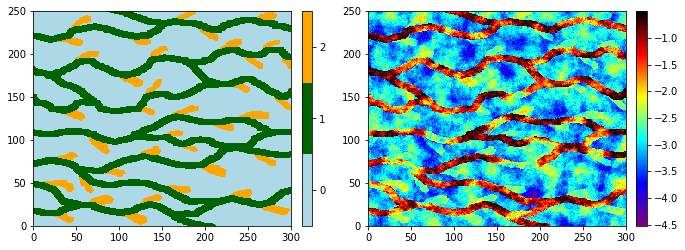

In [3]:
facies_col = ['lightblue', 'darkgreen', 'orange'] # color for facies (1st variable)
vcont_min = ti.vmin()[1] # min TI value of the 2nd variable
vcont_max = ti.vmax()[1] # max TI value of the 2nd variable
vcont_cmap = gn.customcolors.cmap2 # choose a color map for the 2nd variable

# Display
plt.subplots(1, 2, figsize=(11,5)) # 1 x 2 sub-plots

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti, iv=0, categ=True, categCol=facies_col)

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti, iv=1, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max)

plt.show()

## Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [4]:
nx, ny, nz = 100, 100, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

## Hard data
Define some hard data (point set). Note that some points can have only one variable uninformed, in that case the value `np.nan` or `MPDS_MISSING_VALUE` (imported from `geone.deesse_core.deesse`) is used.

In [5]:
npt = 5 # number of points
nv = 5   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'facies', 'vcont'] # list of variable names
v = np.array([
    [ 10.5,  40.5, 0.5,  1,      -1.2], # x, y, z, facies, vcont: 1st point
    [ 50.5,  35.5, 0.5,  np.nan, -0.8], # ...
    [ 90.5,  48.5, 0.5,  1,      np.nan],
    [ 75.5,  50.5, 0.5,  0,      -4.0],
    [ 20.5,  80.5, 0.5,  2,      -2.0]    
    ]).T # variable values: (nv, npt)-array
hd = gn.img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

Set colors for hard data cells (for further plots).

In [6]:
# Get index of hard data for the 1st variable ('facies')
hd_index0 = np.where(~np.isnan(hd.val[3]))[0]
# Set corresponding colors
hd_col0 = [facies_col[int(hd.val[3][i])] for i in hd_index0]
# ... or convert the color to 'rgba' if required
##import matplotlib.colors
##hd_col0=[matplotlib.colors.to_rgba(col[int(hd.val[3][i])] for i in hd_index0]

# Get index of hard data for the 2nd variable ('vcont')
hd_index1 = np.where(~np.isnan(hd.val[4]))[0]
# Set corresponding colors (from the chosen color map 'vcont_cmap' 
# between values vcont_min and vcont_max)
hd_col1 = [vcont_cmap((hd.val[4][i] - vcont_min)/(vcont_max - vcont_min)) for i in hd_index1]

## Fill the input structure for deesse and launch deesse
**Reminder:** variable names for the hard data (in `hd.varname`) and for the simulated variables (`varname` below) should correspond (otherwise, the hard data will be ignored).

In [7]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['facies', 'vcont'], # number of variable(s), name of the variable(s)
    nTI=1, TI=ti,
    dataPointSet=hd,
    distanceType=['categorical', 'continuous'], # distance type for each variable
    nneighboringNode=[12, 12],      # max. number of neighbors (for the patterns), for each variable
    distanceThreshold=[.05,.02],    # acceptation threshold (for distance between patterns), for each variable
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20210922 / OpenMP 7 thread(s)]
* checking out license OK.
DeeSse run complete


## Retrieve the results (and display)

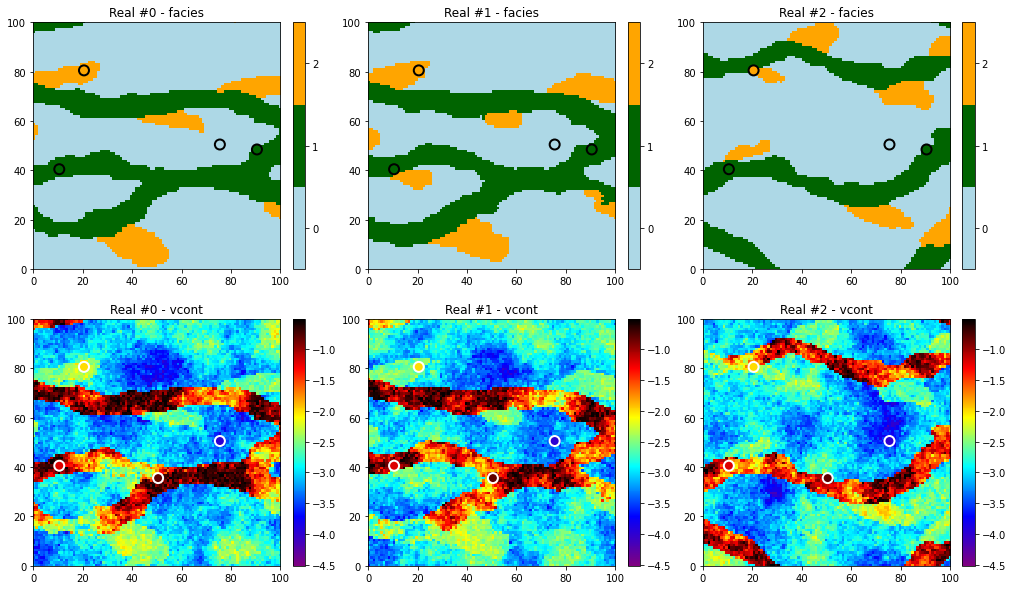

In [8]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots

# ... plot the 1st variable of the three first realizations
iv = 0
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, categ=True, categCol=facies_col, 
                           title='Real #{} - {}'.format(i, deesse_input.varname[iv]))
    plt.scatter(hd.x()[hd_index0], hd.y()[hd_index0], marker='o', s=100, 
                color=hd_col0, edgecolors='black', linewidths=2) # add hard data points

# ... plot the 2nd variable of the three first realizations
iv = 1
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max, 
                           title='Real #{} - {}'.format(i, deesse_input.varname[iv]))
    plt.scatter(hd.x()[hd_index1], hd.y()[hd_index1], marker='o', s=100, 
                color=hd_col1, edgecolors='white', linewidths=2) # add hard data points

plt.show()

## Do some statistics on the realizations

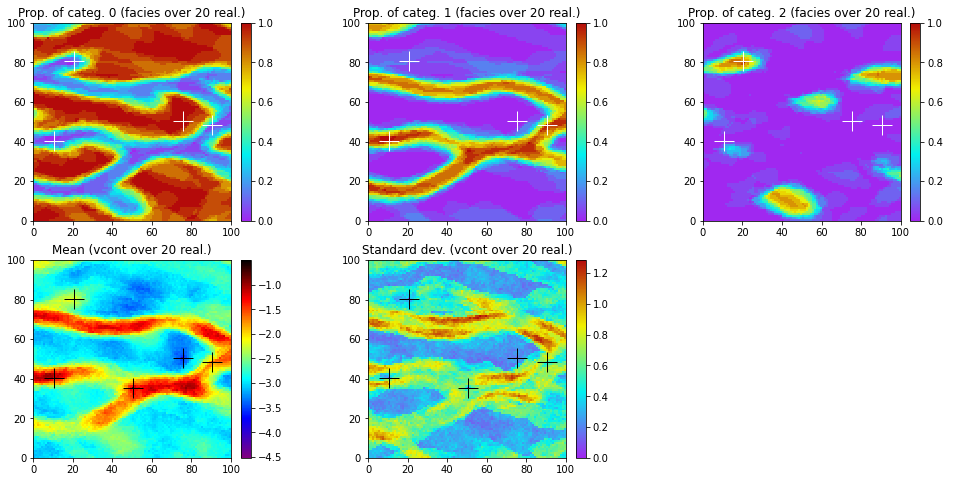

In [9]:
# Do statistics for the 1st variable over all the realizations
# ... gather the nreal realizations of 1st variable into one image
all_sim0 = gn.img.gatherImages(sim, varInd=0) # all_sim is one image with nreal variables (all 1st variables)
# ... compute the pixel-wise proportion for the given categories
all_sim0_stats = gn.img.imageCategProp(all_sim0, [0, 1, 2])

# Do statistics for the 2nd variable over all the realizations
# ... gather the nreal realizations of 2nd variable into one image
all_sim1 = gn.img.gatherImages(sim, varInd=1) # all_sim is one image with nreal variables (all 2nd variables)
# ... compute the pixel-wise mean and standard deviation
all_sim1_mean = gn.img.imageContStat(all_sim1, 'mean')
all_sim1_std = gn.img.imageContStat(all_sim1, 'std')

# Display
plt.subplots(2, 3, figsize=(17,8)) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim0_stats, iv=i, 
        title='Prop. of categ. {} ({} over {} real.)'.format(i, deesse_input.varname[0], nreal))
    plt.plot(hd.x()[hd_index0], hd.y()[hd_index0], '+', markersize=20, c='white') # add hard data points

    
plt.subplot(2,3,4) # select next sub-plot
gn.imgplot.drawImage2D(all_sim1_mean, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max,
                       title='Mean ({} over {} real.)'.format(deesse_input.varname[1], nreal))
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.subplot(2,3,5) # select 2nd sub-plot
gn.imgplot.drawImage2D(all_sim1_std, 
                       title='Standard dev. ({} over {} real.)'.format(deesse_input.varname[1], nreal))
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.subplot(2,3,6) # select 2nd sub-plot
plt.axis('off') # no plot

plt.show()

## Simulations using pyramids
Enabling pyramids implies multi-resolution simulations, which can help to better reproduce the spatial structures.

In [10]:
# Deesse input
#   - with 2 additional levels (npyramidLevel=2) 
#     and a reduction factor of 2 along x and y axes between the original image 
#     and the 1st pyramid level and between the 1st pyramid level to the second one 
#     (kx=[2, 2], ky=[2, 2], kz=[0, 0]: do not apply reduction along z axis)
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(npyramidLevel=2, kx=[2, 2], ky=[2, 2], kz=[0, 0])
pyrParams = [gn.deesseinterface.PyramidParameters(nlevel=2, pyramidType='categorical_auto'), # for 1st variable
             gn.deesseinterface.PyramidParameters(nlevel=2, pyramidType='continuous')]       # for 2nd variable

nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['facies', 'vcont'], # number of variable(s), name of the variable(s)
    nTI=1, TI=ti,
    dataPointSet=hd,
    distanceType=['categorical', 'continuous'], # distance type for each variable
    nneighboringNode=[12, 12],      # max. number of neighbors (for the patterns), for each variable
    distanceThreshold=[.05,.02],    # acceptation threshold (for distance between patterns), for each variable
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # pyramid general parameters
    pyramidParameters=pyrParams,           # pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20210922 / OpenMP 7 thread(s)]
* checking out license OK.
DeeSse run complete


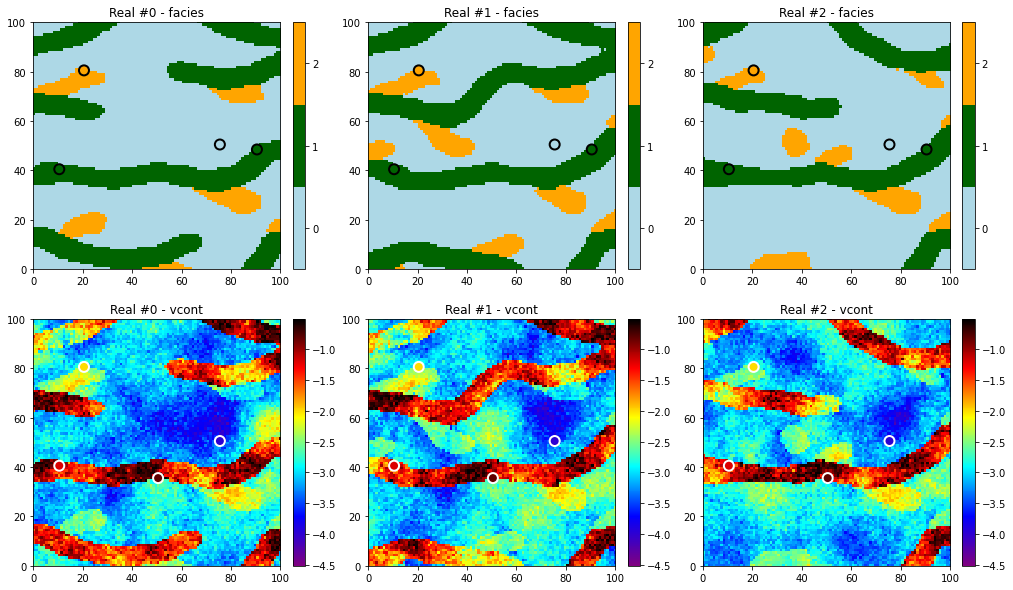

In [11]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display 
plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots

# ... plot the 1st variable of the three first realizations
iv = 0
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, categ=True, categCol=facies_col, 
                           title='Real #{} - {}'.format(i, deesse_input.varname[iv]))
    plt.scatter(hd.x()[hd_index0], hd.y()[hd_index0], marker='o', s=100, 
                color=hd_col0, edgecolors='black', linewidths=2) # add hard data points

# ... plot the 2nd variable of the three first realizations
iv = 1
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], iv=iv, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max, 
                           title='Real #{} - {}'.format(i, deesse_input.varname[iv]))
    plt.scatter(hd.x()[hd_index1], hd.y()[hd_index1], marker='o', s=100, 
                color=hd_col1, edgecolors='white', linewidths=2) # add hard data points

plt.show()

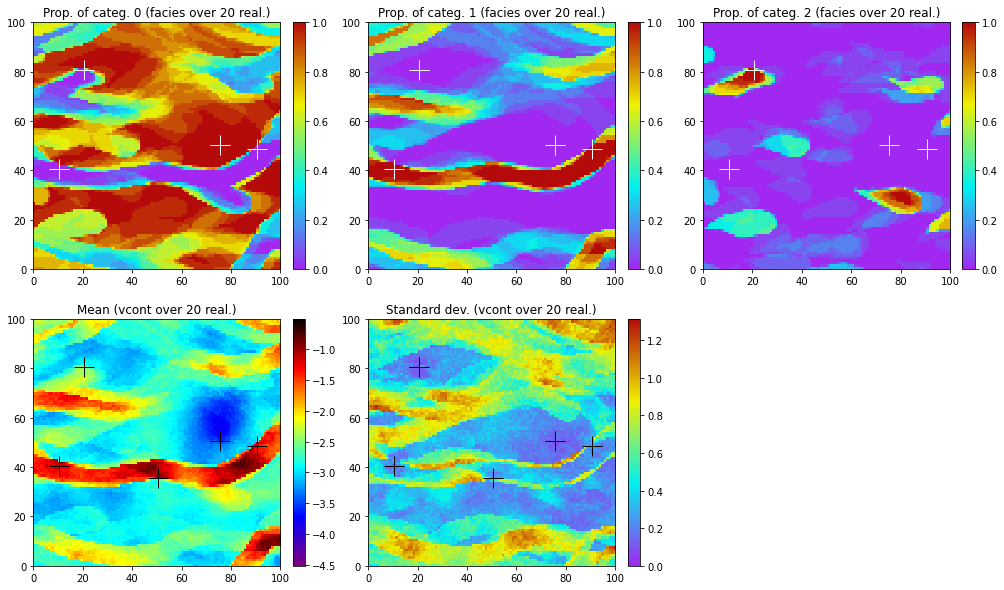

In [12]:
# Do statistics for the 1st variable over all the realizations
# ... gather the nreal realizations of 1st variable into one image
all_sim0 = gn.img.gatherImages(sim, varInd=0) # all_sim is one image with nreal variables (all 1st variables)
# ... compute the pixel-wise proportion for the given categories
all_sim0_stats = gn.img.imageCategProp(all_sim0, [0, 1, 2])

# Do statistics for the 2nd variable over all the realizations
# ... gather the nreal realizations of 2nd variable into one image
all_sim1 = gn.img.gatherImages(sim, varInd=1) # all_sim is one image with nreal variables (all 2nd variables)
# ... compute the pixel-wise mean and standard deviation
all_sim1_mean = gn.img.imageContStat(all_sim1, 'mean')
all_sim1_std = gn.img.imageContStat(all_sim1, 'std')

# Display
plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots

for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim0_stats, iv=i, 
        title='Prop. of categ. {} ({} over {} real.)'.format(i, deesse_input.varname[0], nreal))
    plt.plot(hd.x()[hd_index0], hd.y()[hd_index0], '+', markersize=20, c='white') # add hard data points

    
plt.subplot(2,3,4) # select next sub-plot
gn.imgplot.drawImage2D(all_sim1_mean, cmap=vcont_cmap, vmin=vcont_min, vmax=vcont_max,
                       title='Mean ({} over {} real.)'.format(deesse_input.varname[1], nreal))
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.subplot(2,3,5) # select 2nd sub-plot
gn.imgplot.drawImage2D(all_sim1_std, 
                       title='Standard dev. ({} over {} real.)'.format(deesse_input.varname[1], nreal))
plt.plot(hd.x(), hd.y(), '+', markersize=20, c='k') # add hard data points

plt.subplot(2,3,6) # select 2nd sub-plot
plt.axis('off') # no plot

plt.show()